# Técnicas de Normalização

Este notebook explora diferentes técnicas de normalização utilizadas em redes neurais:

1. **Normalização de Entrada (Input Normalization)**
2. **Normalização em Lote (Batch Normalization)**
3. **Normalização de Camada (Layer Normalization)**

Cada técnica será apresentada com sua fundamentação matemática e implementação direta, mostrando como os dados são transformados.

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Configuração de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Normalização de Entrada (Input Normalization)

### Fundamentação Matemática

A normalização de entrada padroniza os dados de entrada para ter média zero e desvio padrão unitário:

$$\hat{x}_i = \frac{x_i - \mu}{\sigma}$$

Onde:
- $x_i$ é o valor original da feature $i$
- $\mu$ é a média: $\mu = \frac{1}{N}\sum_{i=1}^{N} x_i$
- $\sigma$ é o desvio padrão: $\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \mu)^2}$
- $\hat{x}_i$ é o valor normalizado

### Benefícios:
1. **Acelera a convergência** durante o treinamento
2. **Previne saturação** das funções de ativação
3. **Equaliza a importância** das diferentes features
4. **Melhora a estabilidade numérica**

In [17]:
# Gerando dados sintéticos com escalas diferentes
np.random.seed(42)
n_samples = 1000
n_features = 3

# Features com diferentes escalas e distribuições
feature1 = np.random.normal(100, 20, n_samples)  # Média alta, baixa variância
feature2 = np.random.normal(5, 50, n_samples)    # Média baixa, alta variância
feature3 = np.random.uniform(0, 1000, n_samples) # Distribuição uniforme

data = np.column_stack([feature1, feature2, feature3])

print("Dados originais:")
print(f"Feature 1 - Média: {np.mean(data[:, 0]):.2f}, Desvio: {np.std(data[:, 0]):.2f}")
print(f"Feature 2 - Média: {np.mean(data[:, 1]):.2f}, Desvio: {np.std(data[:, 1]):.2f}")
print(f"Feature 3 - Média: {np.mean(data[:, 2]):.2f}, Desvio: {np.std(data[:, 2]):.2f}")

Dados originais:
Feature 1 - Média: 100.39, Desvio: 19.57
Feature 2 - Média: 8.54, Desvio: 49.85
Feature 3 - Média: 496.85, Desvio: 290.17


In [18]:
# Implementação direta da normalização de entrada (Z-score)
# Calcular média e desvio padrão para cada feature
data_mean = np.mean(data, axis=0)  # Média ao longo das amostras
data_std = np.std(data, axis=0)    # Desvio padrão ao longo das amostras

print("Estatísticas calculadas:")
print(f"Médias: {data_mean}")
print(f"Desvios padrão: {data_std}")

# Aplicar normalização: (x - média) / desvio_padrão
data_normalized = (data - data_mean) / data_std

print("\nDados normalizados:")
print(f"Feature 1 - Média: {np.mean(data_normalized[:, 0]):.6f}, Desvio: {np.std(data_normalized[:, 0]):.6f}")
print(f"Feature 2 - Média: {np.mean(data_normalized[:, 1]):.6f}, Desvio: {np.std(data_normalized[:, 1]):.6f}")
print(f"Feature 3 - Média: {np.mean(data_normalized[:, 2]):.6f}, Desvio: {np.std(data_normalized[:, 2]):.6f}")

Estatísticas calculadas:
Médias: [100.38664112   8.54181186 496.84845258]
Desvios padrão: [ 19.57452415  49.84777626 290.1728649 ]

Dados normalizados:
Feature 1 - Média: -0.000000, Desvio: 1.000000
Feature 2 - Média: 0.000000, Desvio: 1.000000
Feature 3 - Média: 0.000000, Desvio: 1.000000


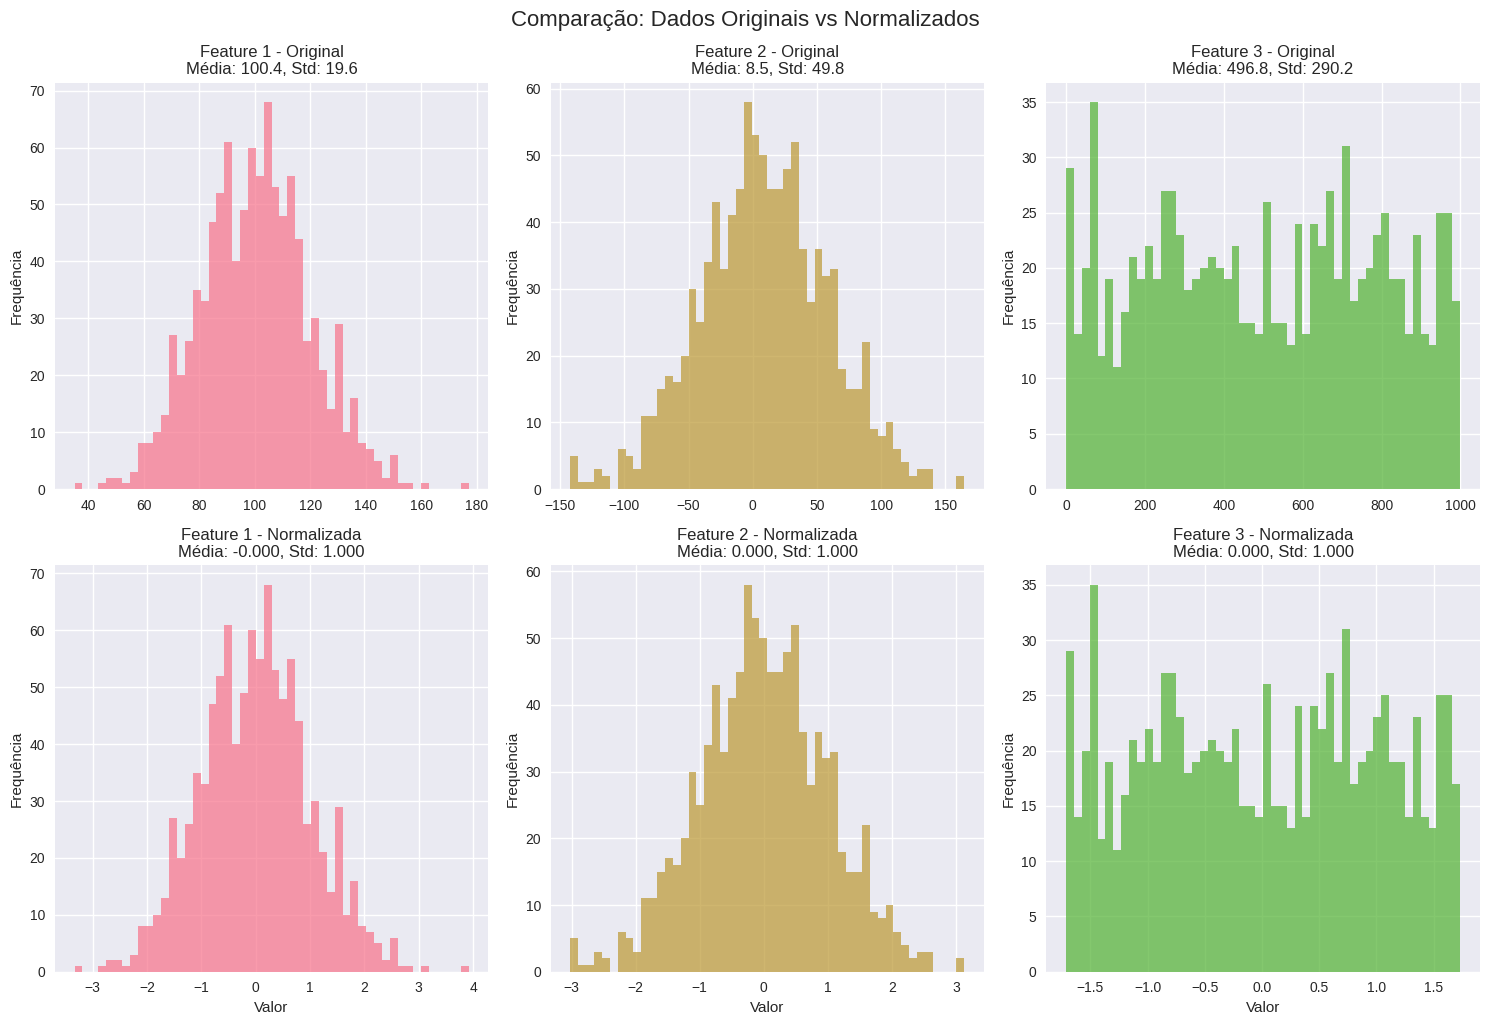

In [19]:
# Visualização da normalização de entrada
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Dados originais
for i in range(3):
    axes[0, i].hist(data[:, i], bins=50, alpha=0.7, color=f'C{i}')
    axes[0, i].set_title(f'Feature {i+1} - Original\nMédia: {np.mean(data[:, i]):.1f}, Std: {np.std(data[:, i]):.1f}')
    axes[0, i].set_ylabel('Frequência')

# Dados normalizados
for i in range(3):
    axes[1, i].hist(data_normalized[:, i], bins=50, alpha=0.7, color=f'C{i}')
    axes[1, i].set_title(f'Feature {i+1} - Normalizada\nMédia: {np.mean(data_normalized[:, i]):.3f}, Std: {np.std(data_normalized[:, i]):.3f}')
    axes[1, i].set_xlabel('Valor')
    axes[1, i].set_ylabel('Frequência')

plt.tight_layout()
plt.suptitle('Comparação: Dados Originais vs Normalizados', y=1.02, fontsize=16)
plt.show()

## 2. Normalização em Lote (Batch Normalization)

### Fundamentação Matemática

A Batch Normalization normaliza as ativações de uma camada ao longo da dimensão do batch:

**Passo 1:** Calcular estatísticas do batch
$$\mu_B = \frac{1}{m}\sum_{i=1}^{m} x_i$$
$$\sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu_B)^2$$

**Passo 2:** Normalizar
$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

**Passo 3:** Escalar e deslocar (parâmetros aprendíveis)
$$y_i = \gamma \hat{x}_i + \beta$$

Onde:
- $m$ é o tamanho do batch
- $\epsilon$ é uma constante pequena para estabilidade numérica (tipicamente $10^{-5}$)
- $\gamma$ e $\beta$ são parâmetros aprendíveis (scale e shift)

### Benefícios:
1. **Reduz o Internal Covariate Shift**
2. **Permite taxas de aprendizado maiores**
3. **Atua como regularizador**
4. **Reduz dependência da inicialização**

In [20]:
# Simulando ativações de uma camada neural
batch_size = 32
n_features = 10

# Ativações não normalizadas (simulando saída de uma camada linear)
x = np.random.normal(5, 2, (batch_size, n_features))  # Média 5, std 2

print("Ativações antes da Batch Norm:")
print(f"Shape: {x.shape} (batch_size, features)")
print(f"Média geral: {np.mean(x):.3f}")
print(f"Desvio padrão geral: {np.std(x):.3f}")
print(f"Média por feature (primeiras 5): {np.mean(x, axis=0)[:5]}")
print(f"Desvio padrão por feature (primeiras 5): {np.std(x, axis=0)[:5]}")

Ativações antes da Batch Norm:
Shape: (32, 10) (batch_size, features)
Média geral: 4.911
Desvio padrão geral: 2.074
Média por feature (primeiras 5): [5.0956405  4.53689124 5.03250285 5.11304062 4.24330562]
Desvio padrão por feature (primeiras 5): [1.82997438 2.19427291 1.91509102 1.83862279 2.1537827 ]


In [21]:
# Implementação direta da Batch Normalization

# Passo 1: Calcular estatísticas do batch
batch_mean = np.mean(x, axis=0)  # Média ao longo do batch (para cada feature)
batch_var = np.var(x, axis=0)    # Variância ao longo do batch (para cada feature)

print("Passo 1 - Estatísticas do batch:")
print(f"Média do batch por feature: {batch_mean[:5]}...")
print(f"Variância do batch por feature: {batch_var[:5]}...")

# Passo 2: Normalizar
eps = 1e-5  # Epsilon para estabilidade numérica
x_normalized = (x - batch_mean) / np.sqrt(batch_var + eps)

print("\nPasso 2 - Após normalização:")
print(f"Média por feature: {np.mean(x_normalized, axis=0)[:5]}...")
print(f"Desvio padrão por feature: {np.std(x_normalized, axis=0)[:5]}...")

# Passo 3: Escalar e deslocar (inicialização padrão)
gamma = np.ones(n_features)    # Parâmetro de escala (inicializado com 1)
beta = np.zeros(n_features)    # Parâmetro de deslocamento (inicializado com 0)

y = gamma * x_normalized + beta

print("\nPasso 3 - Após escalar e deslocar:")
print(f"Gamma (primeiros 5): {gamma[:5]}")
print(f"Beta (primeiros 5): {beta[:5]}")
print(f"Saída final - média por feature: {np.mean(y, axis=0)[:5]}...")
print(f"Saída final - desvio padrão por feature: {np.std(y, axis=0)[:5]}...")

Passo 1 - Estatísticas do batch:
Média do batch por feature: [5.0956405  4.53689124 5.03250285 5.11304062 4.24330562]...
Variância do batch por feature: [3.34880622 4.81483359 3.66757362 3.38053377 4.63877992]...

Passo 2 - Após normalização:
Média por feature: [-7.70217223e-16 -5.06539255e-16  2.68882139e-16  6.93889390e-17
 -1.63064007e-16]...
Desvio padrão por feature: [0.99999851 0.99999896 0.99999864 0.99999852 0.99999892]...

Passo 3 - Após escalar e deslocar:
Gamma (primeiros 5): [1. 1. 1. 1. 1.]
Beta (primeiros 5): [0. 0. 0. 0. 0.]
Saída final - média por feature: [-7.70217223e-16 -5.06539255e-16  2.68882139e-16  6.93889390e-17
 -1.63064007e-16]...
Saída final - desvio padrão por feature: [0.99999851 0.99999896 0.99999864 0.99999852 0.99999892]...


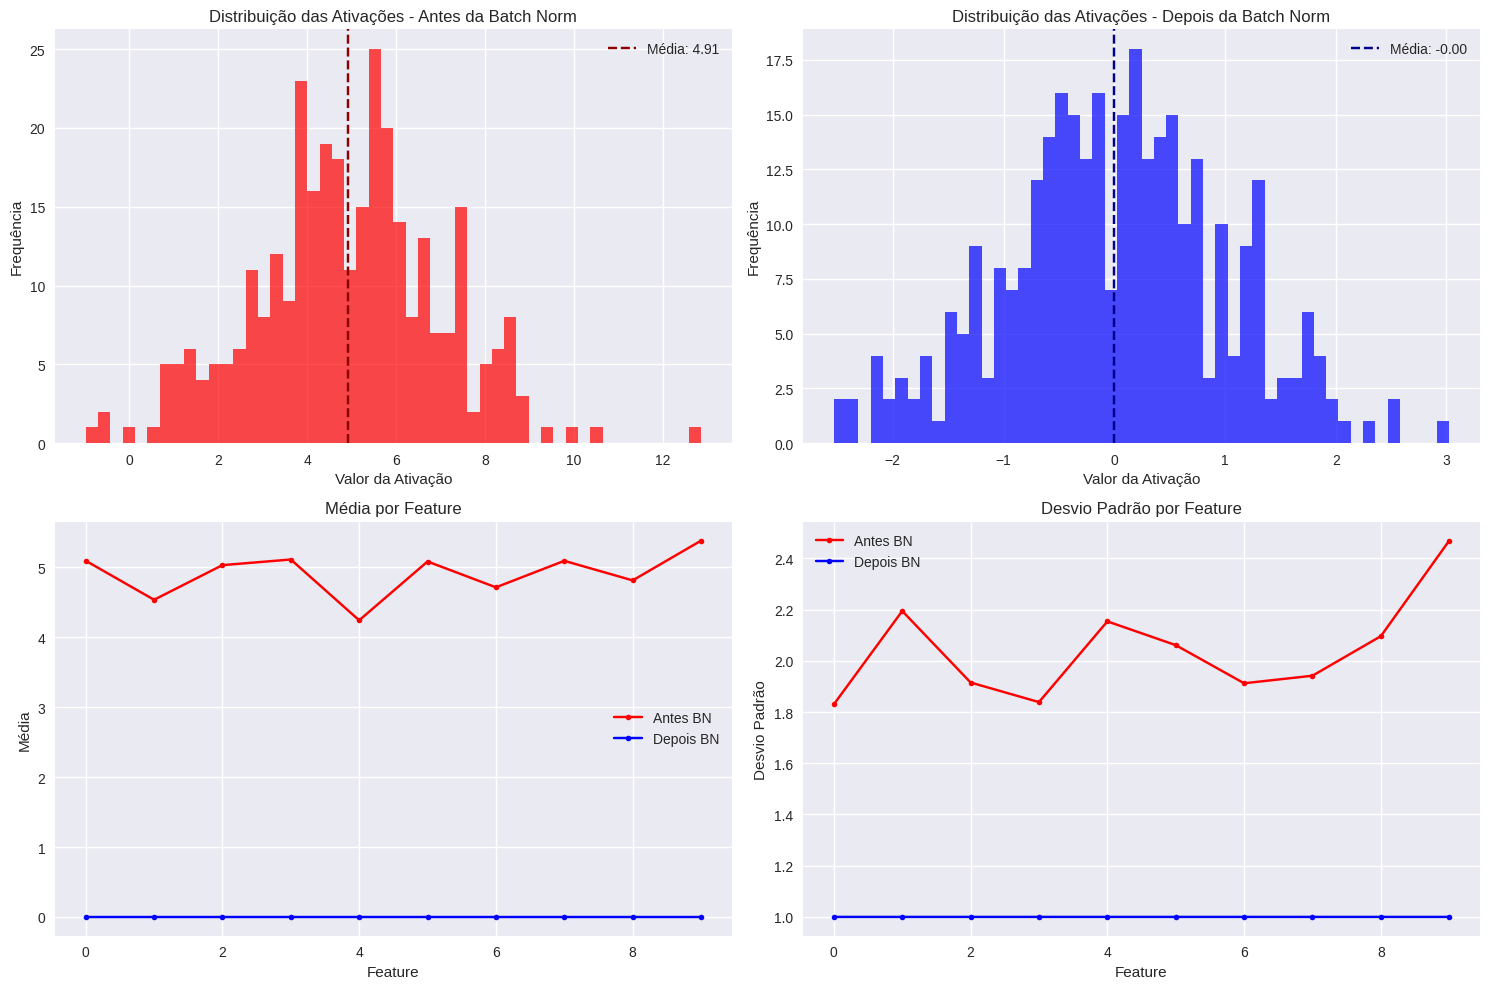

In [22]:
# Visualização dos efeitos da Batch Normalization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma das ativações antes da normalização
axes[0, 0].hist(x.flatten(), bins=50, alpha=0.7, color='red')
axes[0, 0].set_title('Distribuição das Ativações - Antes da Batch Norm')
axes[0, 0].set_xlabel('Valor da Ativação')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(np.mean(x), color='darkred', linestyle='--', label=f'Média: {np.mean(x):.2f}')
axes[0, 0].legend()

# Histograma das ativações depois da normalização
axes[0, 1].hist(y.flatten(), bins=50, alpha=0.7, color='blue')
axes[0, 1].set_title('Distribuição das Ativações - Depois da Batch Norm')
axes[0, 1].set_xlabel('Valor da Ativação')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(np.mean(y), color='darkblue', linestyle='--', label=f'Média: {np.mean(y):.2f}')
axes[0, 1].legend()

# Comparação das médias por feature
features = range(n_features)
axes[1, 0].plot(features, np.mean(x, axis=0), 'ro-', label='Antes BN', markersize=4)
axes[1, 0].plot(features, np.mean(y, axis=0), 'bo-', label='Depois BN', markersize=4)
axes[1, 0].set_title('Média por Feature')
axes[1, 0].set_xlabel('Feature')
axes[1, 0].set_ylabel('Média')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Comparação dos desvios padrão por feature
axes[1, 1].plot(features, np.std(x, axis=0), 'ro-', label='Antes BN', markersize=4)
axes[1, 1].plot(features, np.std(y, axis=0), 'bo-', label='Depois BN', markersize=4)
axes[1, 1].set_title('Desvio Padrão por Feature')
axes[1, 1].set_xlabel('Feature')
axes[1, 1].set_ylabel('Desvio Padrão')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 3. Normalização de Camada (Layer Normalization)

### Fundamentação Matemática

A Layer Normalization normaliza as ativações ao longo da dimensão das features (em vez do batch):

**Passo 1:** Calcular estatísticas da camada para cada amostra
$$\mu^{(i)} = \frac{1}{H}\sum_{j=1}^{H} x_j^{(i)}$$
$$\sigma^{(i)2} = \frac{1}{H}\sum_{j=1}^{H}(x_j^{(i)} - \mu^{(i)})^2$$

**Passo 2:** Normalizar
$$\hat{x}_j^{(i)} = \frac{x_j^{(i)} - \mu^{(i)}}{\sqrt{\sigma^{(i)2} + \epsilon}}$$

**Passo 3:** Escalar e deslocar
$$y_j^{(i)} = \gamma_j \hat{x}_j^{(i)} + \beta_j$$

Onde:
- $i$ indexa as amostras no batch
- $j$ indexa as features
- $H$ é o número de features

### Diferenças da Batch Normalization:
1. **Independente do batch size**
2. **Funciona bem em RNNs**
3. **Comportamento idêntico em treino e teste**
4. **Normaliza ao longo das features, não das amostras**

In [23]:
# Usar as mesmas ativações do exemplo anterior
print("Ativações antes da Layer Norm:")
print(f"Shape: {x.shape} (batch_size, features)")
print(f"Média por amostra (primeiras 5): {np.mean(x, axis=1)[:5]}")
print(f"Desvio padrão por amostra (primeiras 5): {np.std(x, axis=1)[:5]}")

Ativações antes da Layer Norm:
Shape: (32, 10) (batch_size, features)
Média por amostra (primeiras 5): [4.8159284  5.55283757 5.01616264 4.97743318 5.75948808]
Desvio padrão por amostra (primeiras 5): [2.46851886 1.85922743 1.99142527 1.8996359  2.60456612]


In [24]:
# Implementação direta da Layer Normalization

# Passo 1: Calcular estatísticas da camada para cada amostra
layer_mean = np.mean(x, axis=1, keepdims=True)  # Média ao longo das features (para cada amostra)
layer_var = np.var(x, axis=1, keepdims=True)    # Variância ao longo das features (para cada amostra)

print("Passo 1 - Estatísticas da camada:")
print(f"Shape das médias: {layer_mean.shape}")
print(f"Média por amostra (primeiras 5): {layer_mean[:5, 0]}")
print(f"Variância por amostra (primeiras 5): {layer_var[:5, 0]}")

# Passo 2: Normalizar
eps = 1e-5
x_ln_normalized = (x - layer_mean) / np.sqrt(layer_var + eps)

print("\nPasso 2 - Após normalização:")
print(f"Média por amostra: {np.mean(x_ln_normalized, axis=1)[:5]}")
print(f"Desvio padrão por amostra: {np.std(x_ln_normalized, axis=1)[:5]}")

# Passo 3: Escalar e deslocar
gamma_ln = np.ones(n_features)    # Parâmetro de escala
beta_ln = np.zeros(n_features)    # Parâmetro de deslocamento

y_ln = gamma_ln * x_ln_normalized + beta_ln

print("\nPasso 3 - Após escalar e deslocar:")
print(f"Saída final - média por amostra: {np.mean(y_ln, axis=1)[:5]}")
print(f"Saída final - desvio padrão por amostra: {np.std(y_ln, axis=1)[:5]}")

Passo 1 - Estatísticas da camada:
Shape das médias: (32, 1)
Média por amostra (primeiras 5): [4.8159284  5.55283757 5.01616264 4.97743318 5.75948808]
Variância por amostra (primeiras 5): [6.09358538 3.45672662 3.9657746  3.60861655 6.78376465]

Passo 2 - Após normalização:
Média por amostra: [ 2.22044605e-16 -1.77635684e-16  8.88178420e-17 -3.99680289e-16
  1.77635684e-16]
Desvio padrão por amostra: [0.99999918 0.99999855 0.99999874 0.99999861 0.99999926]

Passo 3 - Após escalar e deslocar:
Saída final - média por amostra: [ 2.22044605e-16 -1.77635684e-16  8.88178420e-17 -3.99680289e-16
  1.77635684e-16]
Saída final - desvio padrão por amostra: [0.99999918 0.99999855 0.99999874 0.99999861 0.99999926]


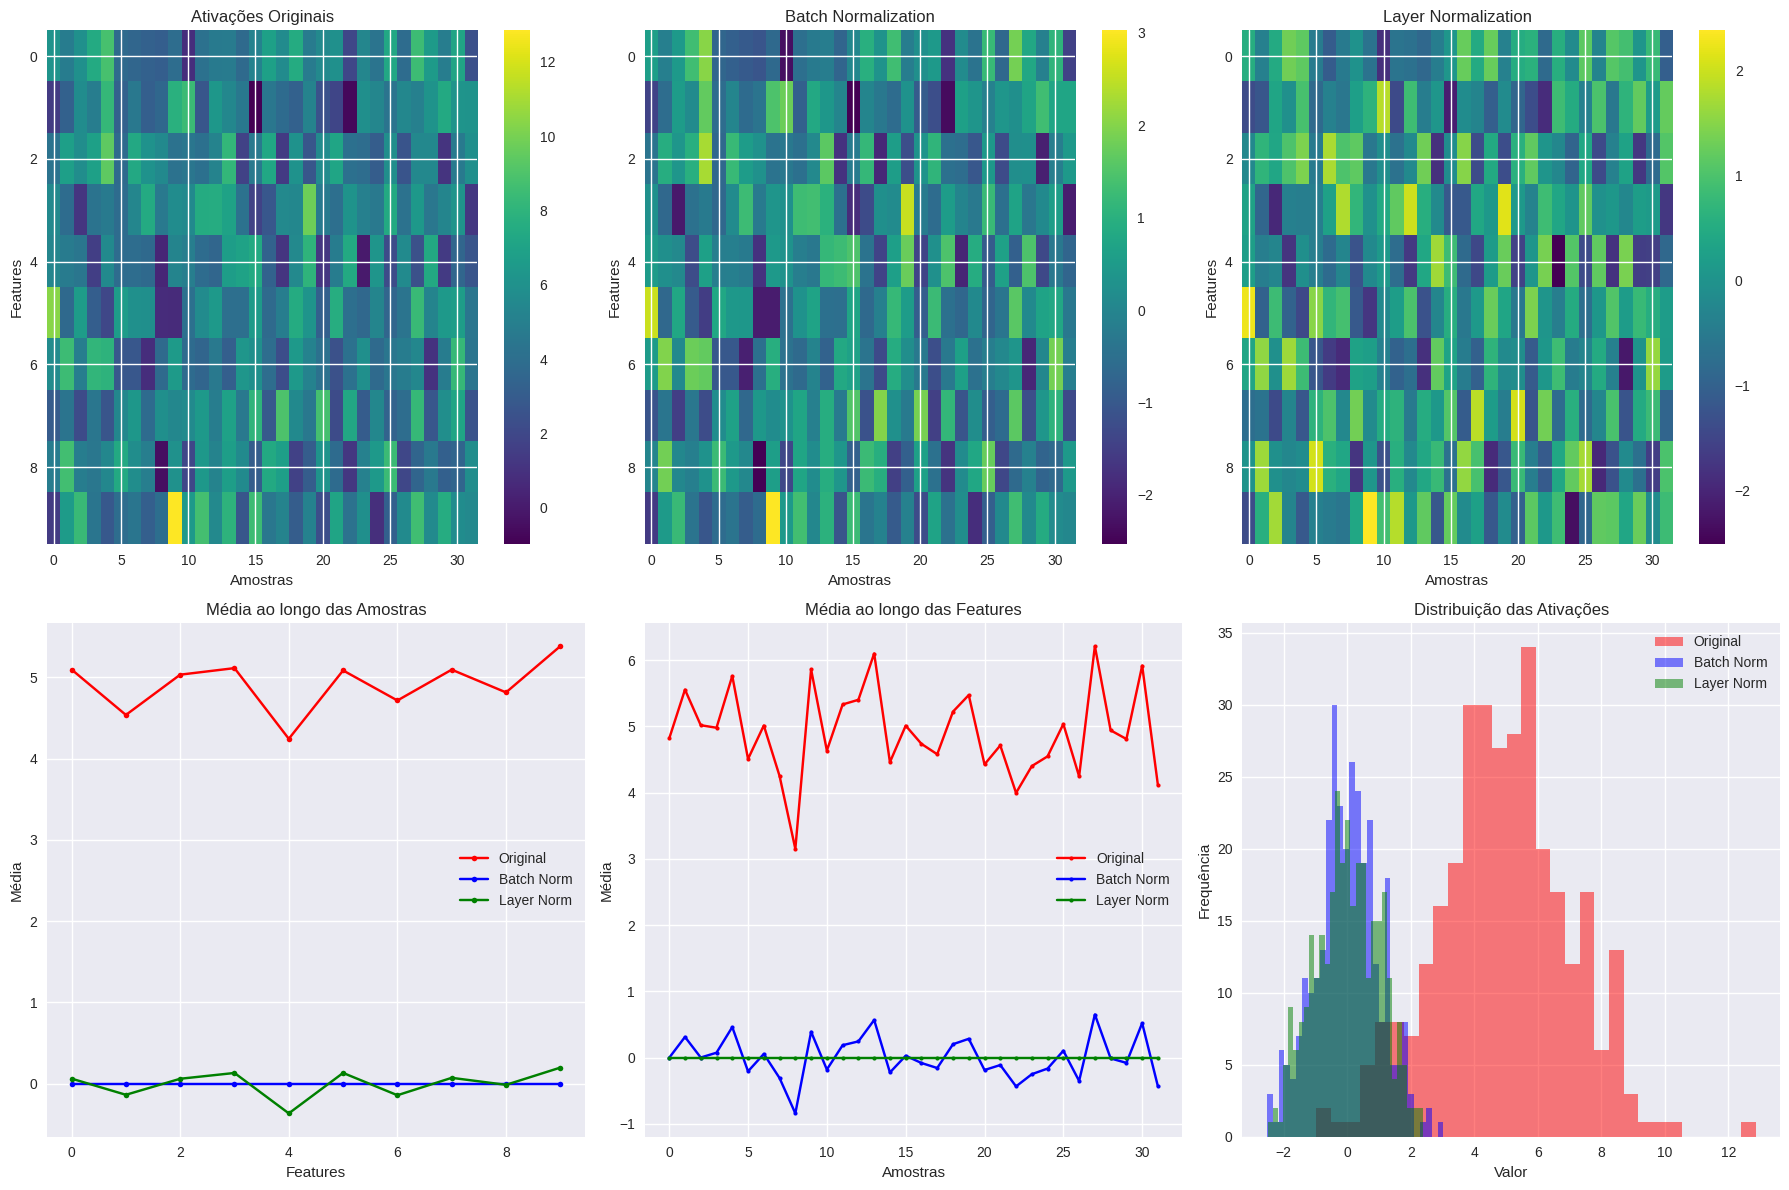

In [25]:
# Comparação visual entre Batch Norm e Layer Norm
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Dados originais como heatmap
im1 = axes[0, 0].imshow(x.T, cmap='viridis', aspect='auto')
axes[0, 0].set_title('Ativações Originais')
axes[0, 0].set_xlabel('Amostras')
axes[0, 0].set_ylabel('Features')
plt.colorbar(im1, ax=axes[0, 0])

# Batch Normalization
im2 = axes[0, 1].imshow(y.T, cmap='viridis', aspect='auto')
axes[0, 1].set_title('Batch Normalization')
axes[0, 1].set_xlabel('Amostras')
axes[0, 1].set_ylabel('Features')
plt.colorbar(im2, ax=axes[0, 1])

# Layer Normalization
im3 = axes[0, 2].imshow(y_ln.T, cmap='viridis', aspect='auto')
axes[0, 2].set_title('Layer Normalization')
axes[0, 2].set_xlabel('Amostras')
axes[0, 2].set_ylabel('Features')
plt.colorbar(im3, ax=axes[0, 2])

# Estatísticas por dimensão
samples = range(batch_size)
features = range(n_features)

# Média ao longo das amostras (Batch Norm normaliza isso)
axes[1, 0].plot(features, np.mean(x, axis=0), 'ro-', label='Original', markersize=4)
axes[1, 0].plot(features, np.mean(y, axis=0), 'bo-', label='Batch Norm', markersize=4)
axes[1, 0].plot(features, np.mean(y_ln, axis=0), 'go-', label='Layer Norm', markersize=4)
axes[1, 0].set_title('Média ao longo das Amostras')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Média')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Média ao longo das features (Layer Norm normaliza isso)
axes[1, 1].plot(samples, np.mean(x, axis=1), 'ro-', label='Original', markersize=3)
axes[1, 1].plot(samples, np.mean(y, axis=1), 'bo-', label='Batch Norm', markersize=3)
axes[1, 1].plot(samples, np.mean(y_ln, axis=1), 'go-', label='Layer Norm', markersize=3)
axes[1, 1].set_title('Média ao longo das Features')
axes[1, 1].set_xlabel('Amostras')
axes[1, 1].set_ylabel('Média')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Distribuição geral
axes[1, 2].hist(x.flatten(), bins=30, alpha=0.5, label='Original', color='red')
axes[1, 2].hist(y.flatten(), bins=30, alpha=0.5, label='Batch Norm', color='blue')
axes[1, 2].hist(y_ln.flatten(), bins=30, alpha=0.5, label='Layer Norm', color='green')
axes[1, 2].set_title('Distribuição das Ativações')
axes[1, 2].set_xlabel('Valor')
axes[1, 2].set_ylabel('Frequência')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## 4. Comparação das Técnicas

### Resumo das Diferenças:

| Técnica | Normaliza ao longo de | Parâmetros Aprendíveis | Uso Principal |
|---------|----------------------|------------------------|---------------|
| **Input Norm** | Amostras (features) | Não | Pré-processamento |
| **Batch Norm** | Batch (amostras) | Sim (γ, β) | CNNs, MLPs |
| **Layer Norm** | Features (camada) | Sim (γ, β) | RNNs, Transformers |

In [26]:
# Demonstração do comportamento com diferentes batch sizes
print("Efeito do batch size na Batch Normalization:")
print("=" * 50)

batch_sizes = [4, 16, 64]
n_features = 10

for bs in batch_sizes:
    # Gerar dados com distribuição fixa
    x_test = np.random.normal(10, 3, (bs, n_features))

    # Aplicar Batch Normalization
    batch_mean = np.mean(x_test, axis=0)
    batch_var = np.var(x_test, axis=0)
    x_bn = (x_test - batch_mean) / np.sqrt(batch_var + 1e-5)

    # Aplicar Layer Normalization
    layer_mean = np.mean(x_test, axis=1, keepdims=True)
    layer_var = np.var(x_test, axis=1, keepdims=True)
    x_ln = (x_test - layer_mean) / np.sqrt(layer_var + 1e-5)

    print(f"\nBatch Size: {bs}")
    print(f"Batch Norm - Consistência da normalização: {np.std(np.var(x_bn, axis=0)):.4f}")
    print(f"Layer Norm - Consistência da normalização: {np.std(np.var(x_ln, axis=1)):.4f}")

print("\nObservação: Batch Norm é mais instável com batches pequenos")
print("Layer Norm mantém comportamento consistente independente do batch size")

Efeito do batch size na Batch Normalization:

Batch Size: 4
Batch Norm - Consistência da normalização: 0.0000
Layer Norm - Consistência da normalização: 0.0000

Batch Size: 16
Batch Norm - Consistência da normalização: 0.0000
Layer Norm - Consistência da normalização: 0.0000

Batch Size: 64
Batch Norm - Consistência da normalização: 0.0000
Layer Norm - Consistência da normalização: 0.0000

Observação: Batch Norm é mais instável com batches pequenos
Layer Norm mantém comportamento consistente independente do batch size


## 5. Implementações no PyTorch

Agora vamos ver como usar as implementações otimizadas do PyTorch para cada técnica de normalização.

In [27]:
# 1. Input Normalization com PyTorch
print("1. Input Normalization com PyTorch:")
print("=" * 40)

# Converter dados para tensor PyTorch
data_tensor = torch.tensor(data, dtype=torch.float32)

# Normalização manual
mean_torch = torch.mean(data_tensor, dim=0)
std_torch = torch.std(data_tensor, dim=0)
normalized_torch = (data_tensor - mean_torch) / std_torch

print(f"Original shape: {data_tensor.shape}")
print(f"Média após normalização: {torch.mean(normalized_torch, dim=0)[:3]}")
print(f"Std após normalização: {torch.std(normalized_torch, dim=0)[:3]}")

# Comparação com sklearn StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_sklearn = scaler.fit_transform(data)

print(f"\nComparação com sklearn - diferença máxima: {np.max(np.abs(normalized_torch.numpy() - normalized_sklearn)):.6f}")

1. Input Normalization com PyTorch:
Original shape: torch.Size([1000, 3])
Média após normalização: tensor([-6.1035e-08,  9.5367e-10,  1.2398e-08])
Std após normalização: tensor([1., 1., 1.])

Comparação com sklearn - diferença máxima: 0.001959


In [28]:
# 2. Batch Normalization com PyTorch
print("2. Batch Normalization com PyTorch:")
print("=" * 40)

# Criar uma camada de Batch Normalization
batch_norm = nn.BatchNorm1d(n_features)

# Dados de teste
test_input = torch.randn(32, n_features)  # Batch de 32 amostras, n_features

print(f"Input shape: {test_input.shape}")
print(f"Input - mean: {test_input.mean().item():.4f}, std: {test_input.std().item():.4f}")

# Aplicar Batch Normalization (modo treino)
batch_norm.train()
output_bn = batch_norm(test_input)

print(f"Output BN - mean: {output_bn.mean().item():.6f}, std: {output_bn.std().item():.4f}")

# Mostrar parâmetros aprendíveis
print(f"\nParâmetros do BatchNorm1d:")
print(f"Weight (gamma) shape: {batch_norm.weight.shape}")
print(f"Bias (beta) shape: {batch_norm.bias.shape}")
print(f"Running mean shape: {batch_norm.running_mean.shape}")
print(f"Running var shape: {batch_norm.running_var.shape}")

# Valores iniciais
print(f"\nValores iniciais:")
print(f"Weight (primeiros 5): {batch_norm.weight.data[:5]}")
print(f"Bias (primeiros 5): {batch_norm.bias.data[:5]}")

2. Batch Normalization com PyTorch:
Input shape: torch.Size([32, 10])
Input - mean: 0.0409, std: 0.9993
Output BN - mean: -0.000000, std: 1.0016

Parâmetros do BatchNorm1d:
Weight (gamma) shape: torch.Size([10])
Bias (beta) shape: torch.Size([10])
Running mean shape: torch.Size([10])
Running var shape: torch.Size([10])

Valores iniciais:
Weight (primeiros 5): tensor([1., 1., 1., 1., 1.])
Bias (primeiros 5): tensor([0., 0., 0., 0., 0.])


In [29]:
# 3. Layer Normalization com PyTorch
print("3. Layer Normalization com PyTorch:")
print("=" * 40)

# Criar uma camada de Layer Normalization
layer_norm = nn.LayerNorm(n_features)

# Usar os mesmos dados de teste
print(f"Input shape: {test_input.shape}")
print(f"Input - mean: {test_input.mean().item():.4f}, std: {test_input.std().item():.4f}")

# Aplicar Layer Normalization
output_ln = layer_norm(test_input)

print(f"Output LN - mean: {output_ln.mean().item():.6f}, std: {output_ln.std().item():.4f}")

# Analisar normalização por amostra
sample_means_ln = output_ln.mean(dim=-1)  # Média ao longo da dimensão das features
sample_stds_ln = output_ln.std(dim=-1)    # Std ao longo da dimensão das features

print(f"\nLayer Norm - Médias por amostra (primeiras 5): {sample_means_ln[:5]}")
print(f"Layer Norm - Stds por amostra (primeiras 5): {sample_stds_ln[:5]}")

# Mostrar parâmetros
print(f"\nParâmetros do LayerNorm:")
print(f"Weight (gamma) shape: {layer_norm.weight.shape}")
print(f"Bias (beta) shape: {layer_norm.bias.shape}")
print(f"Weight (primeiros 5): {layer_norm.weight.data[:5]}")
print(f"Bias (primeiros 5): {layer_norm.bias.data[:5]}")

3. Layer Normalization com PyTorch:
Input shape: torch.Size([32, 10])
Input - mean: 0.0409, std: 0.9993
Output LN - mean: -0.000000, std: 1.0016

Layer Norm - Médias por amostra (primeiras 5): tensor([ 3.5763e-08, -2.3562e-08, -1.7881e-08, -1.1921e-08,  2.1979e-08],
       grad_fn=<SliceBackward0>)
Layer Norm - Stds por amostra (primeiras 5): tensor([1.0541, 1.0541, 1.0541, 1.0541, 1.0541], grad_fn=<SliceBackward0>)

Parâmetros do LayerNorm:
Weight (gamma) shape: torch.Size([10])
Bias (beta) shape: torch.Size([10])
Weight (primeiros 5): tensor([1., 1., 1., 1., 1.])
Bias (primeiros 5): tensor([0., 0., 0., 0., 0.])


In [30]:
# 4. Comparação lado a lado das implementações PyTorch
print("Comparação das Normalizações PyTorch:")
print("=" * 45)

# Dados de entrada com características específicas
torch.manual_seed(42)
test_data = torch.randn(16, 8) * 5 + 10  # Média ~10, std ~5

print(f"Dados originais:")
print(f"  Shape: {test_data.shape}")
print(f"  Mean: {test_data.mean().item():.3f}")
print(f"  Std: {test_data.std().item():.3f}")

# Input normalization manual
input_mean = test_data.mean(dim=0)
input_std = test_data.std(dim=0)
input_normalized = (test_data - input_mean) / input_std

# Batch normalization
bn = nn.BatchNorm1d(8)
bn.train()
batch_normalized = bn(test_data)

# Layer normalization
ln = nn.LayerNorm(8)
layer_normalized = ln(test_data)

print(f"\nApós Input Normalization:")
print(f"  Mean: {input_normalized.mean().item():.6f}")
print(f"  Std: {input_normalized.std().item():.6f}")

print(f"\nApós Batch Normalization:")
print(f"  Mean: {batch_normalized.mean().item():.6f}")
print(f"  Std: {batch_normalized.std().item():.6f}")

print(f"\nApós Layer Normalization:")
print(f"  Mean: {layer_normalized.mean().item():.6f}")
print(f"  Std: {layer_normalized.std().item():.6f}")

# Verificar propriedades específicas
print(f"\nPropriedades específicas:")
print(f"Input Norm - std por feature: {input_normalized.std(dim=0)[:3]}...")
print(f"Batch Norm - std por feature: {batch_normalized.std(dim=0)[:3]}...")
print(f"Layer Norm - std por amostra: {layer_normalized.std(dim=1)[:3]}...")

Comparação das Normalizações PyTorch:
Dados originais:
  Shape: torch.Size([16, 8])
  Mean: 10.406
  Std: 4.809

Após Input Normalization:
  Mean: -0.000000
  Std: 0.972050

Após Batch Normalization:
  Mean: -0.000000
  Std: 1.003929

Após Layer Normalization:
  Mean: 0.000000
  Std: 1.003929

Propriedades específicas:
Input Norm - std por feature: tensor([1., 1., 1.])...
Batch Norm - std por feature: tensor([1.0328, 1.0328, 1.0328], grad_fn=<SliceBackward0>)...
Layer Norm - std por amostra: tensor([1.0690, 1.0690, 1.0690], grad_fn=<SliceBackward0>)...


## 6. Resumo e Recomendações de Uso

### Quando Usar Cada Técnica:

1. **Input Normalization (Normalização de Entrada)**
   - **Sempre** aplicar nos dados de entrada
   - Especialmente importante quando features têm escalas muito diferentes
   - Usar StandardScaler ou normalização Z-score

2. **Batch Normalization**
   - **CNNs**: Quase sempre benéfico
   - **MLPs**: Muito útil para redes profundas
   - **Atenção**: Cuidado com batch sizes pequenos
   - **Posição**: Geralmente entre camada linear e ativação

3. **Layer Normalization**
   - **RNNs/LSTMs**: Preferível à Batch Norm
   - **Transformers**: Padrão da arquitetura
   - **Batch sizes variáveis**: Mais estável que Batch Norm
   - **Inferência**: Comportamento idêntico ao treino

### Implementação no PyTorch:

```python
# Input Normalization
mean = X.mean(dim=0)
std = X.std(dim=0)
X_norm = (X - mean) / std

# Batch Normalization
self.bn = nn.BatchNorm1d(num_features)

# Layer Normalization  
self.ln = nn.LayerNorm(normalized_shape)
```

### Considerações Importantes:

- **Batch Norm** requer diferentes comportamentos entre treino e avaliação (`model.train()` vs `model.eval()`)
- **Layer Norm** é determinística e não depende do batch
- **Ambas** introduzem parâmetros aprendíveis (γ e β)
- **Normalização de entrada** é determinística e não tem parâmetros aprendíveis

### Próximos Passos:
- Experimente com diferentes posições das normalizações (antes vs depois da ativação)
- Teste o impacto em diferentes arquiteturas (CNNs, RNNs, Transformers)
- Analise o efeito em diferentes tamanhos de batch
- Compare com outras técnicas como Group Normalization e Instance Normalization